/var/folders/5x/1n063tsx6jx9wzcy34jzlqzh0000gn/T/ipykernel_47010/1625503705.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, Hyperband


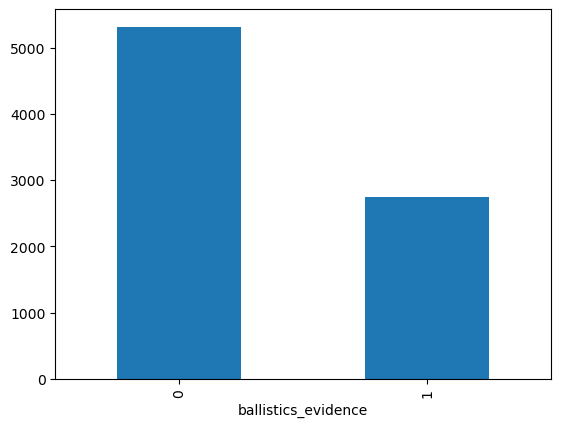

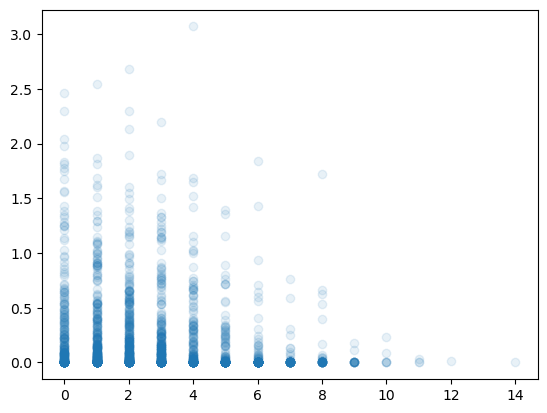

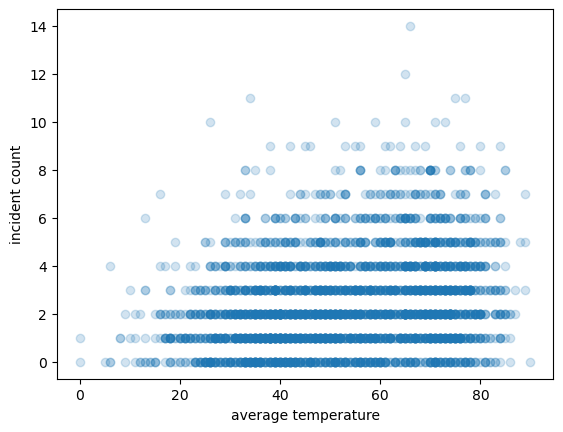

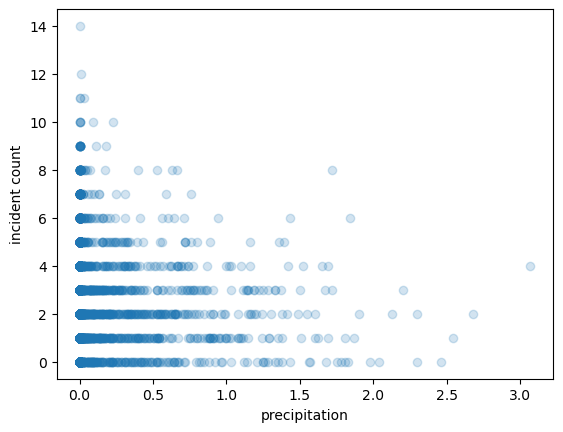

/var/folders/5x/1n063tsx6jx9wzcy34jzlqzh0000gn/T/ipykernel_47010/3579789719.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shots_daily_weather = shots_daily_weather.groupby(['day_of_week']).mean().reset_index()


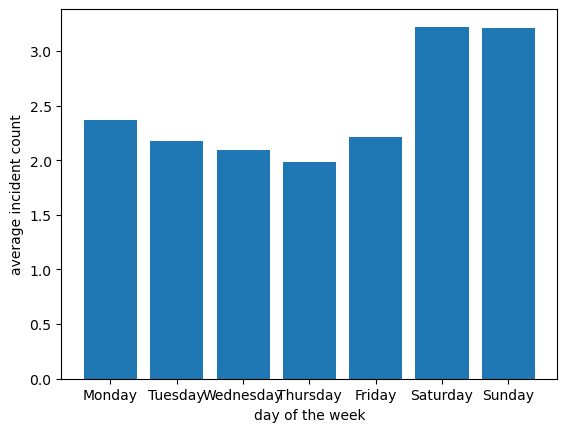

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

from kerastuner import HyperModel, Hyperband

%run 'ShotsFired_DataPipeline.ipynb'

In [2]:
# browsing our pipeline
shots_daily.head()

,DATE,AWND,PRCP,SNOW,TAVG,district,ballistics_evidence,incident_count,daylight_hours,day_of_week,weekend,is_Monday,is_Tuesday,is_Wednesday,is_Thursday,is_Friday,is_Saturday,is_Sunday
0,2015-01-01,14.32,0.00,0.0,26,C11A15,0.0,2.0,12.488967,Thursday,False,False,False,False,True,False,False,False
1,2015-01-02,12.75,0.00,0.0,34,B3E13,1.0,2.0,12.537565,Friday,False,False,False,False,False,True,False,False
2,2015-01-03,10.29,0.62,1.4,28,B2,0.0,1.0,12.586077,Saturday,True,False,False,False,False,False,True,False
3,2015-01-04,8.28,0.57,0.0,38,B2B2,1.0,2.0,12.634493,Sunday,True,False,False,False,False,False,False,True
4,2015-01-05,22.15,0.00,0.0,40,C6,0.0,1.0,12.682807,Monday,False,True,False,False,False,False,False,False


In [3]:
shot_count = 2

# aggregating our labels to see where we can find a signal
shots_daily['incident_count'] = shots_daily['incident_count'].replace(
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 
    '1.0')

shots_daily['incident_count'] = shots_daily['incident_count'].astype('float32')

# helpful to see how many samples we have for each class
# as i play around with the number of shots to aggregate
print(shots_daily['incident_count'].value_counts())

incident_count
1.0    2806
0.0     465
Name: count, dtype: int64


In [4]:
# variables for X and y

X = shots_daily[['TAVG', 'PRCP',
                 'is_Monday', 'is_Tuesday', 'is_Wednesday', 'is_Thursday',
                   'is_Friday', 'is_Saturday', 'is_Sunday']]

# X = shots_daily[['TAVG', 'PRCP', 'is_Saturday', 'is_Sunday']]

y = shots_daily['incident_count']

print('X shape is', X.shape)
print('y shape is', y.shape)

X shape is (3271, 9)
y shape is (3271,)


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [6]:
# # let's normalize our data
# # still working on this but i think it's key to getting our model to work

# shots_daily_norm = shots_daily.copy()

# shots_daily_norm['incident_count'] = (shots_daily_norm['incident_count'] - shots_daily_norm['incident_count'].mean()) / shots_daily_norm['incident_count'].std()
# shots_daily_norm['incident_count'] = shots_daily_norm['incident_count'].astype('float32')

# shots_daily_norm.head()

In [7]:
# # let's normalize all the features except for the binary ones

# shots_daily_norm = shots_daily.copy()

# shots_daily_norm['TAVG'] = (shots_daily_norm['TAVG'] - shots_daily_norm['TAVG'].mean()) / shots_daily_norm['TAVG'].std()
# shots_daily_norm['PRCP'] = (shots_daily_norm['PRCP'] - shots_daily_norm['PRCP'].mean()) / shots_daily_norm['PRCP'].std()
# shots_daily_norm['SNOW'] = (shots_daily_norm['SNOW'] - shots_daily_norm['SNOW'].mean()) / shots_daily_norm['SNOW'].std()
# shots_daily_norm['AWND'] = (shots_daily_norm['AWND'] - shots_daily_norm['AWND'].mean()) / shots_daily_norm['AWND'].std()
# shots_daily_norm['daylight_hours'] = (shots_daily_norm['daylight_hours'] - shots_daily_norm['daylight_hours'].mean()) / shots_daily_norm['daylight_hours'].std()

# # let's also normalize our target variable

# shots_daily_norm['incident_count'] = (shots_daily_norm['incident_count'] - shots_daily_norm['incident_count'].mean()) / shots_daily_norm['incident_count'].std()
# shots_daily_norm['incident_count'] = shots_daily_norm['incident_count'].astype('float32')

# shots_daily_norm.head()

In [8]:
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [9]:
# Calculating class weights, since we have far more
# shooting days than non-shooting days
class_weights = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(y_train),
                                    y=y_train)

# Converting class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

In [10]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')

y_train = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = enc.fit_transform(y_test.reshape(-1, 1)).toarray()

print('y_train shape is', y_train.shape)
print('y_test shape is', y_test.shape)

y_train shape is (2453, 2)
y_test shape is (818, 2)


In [11]:
print('Verifying shapes:')
print('X_train shape is', X_train.shape)
print('y_train shape is', y_train.shape)
print('X_test shape is', X_test.shape)
print('y_test shape is', y_test.shape)

Verifying shapes:
X_train shape is (2453, 9)
y_train shape is (2453, 2)
X_test shape is (818, 9)
y_test shape is (818, 2)


In [13]:
# lets try a different model
# this time let's try AlexNet

model = keras.Sequential([
    keras.layers.BatchNormalization(),

    keras.layers.Dense(256, activation='relu'),
    # keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),

    # keras.layers.Dense(256, activation='relu'),
    # keras.layers.BatchNormalization(),
    # keras.layers.Dropout(0.25),

    # keras.layers.Dense(256, activation='relu'),
    # keras.layers.BatchNormalization(),
    # keras.layers.Dropout(0.25),

    # keras.layers.Dense(256, activation='relu'),
    # keras.layers.BatchNormalization(),
    # keras.layers.Dropout(0.25),

    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.BatchNormalization(),
    # keras.layers.Dropout(0.25),

    # keras.layers.Dense(512, activation='relu'),
    # keras.layers.BatchNormalization(),
    # keras.layers.Dropout(0.25),

    # keras.layers.Dense(512, activation='relu'),
    # keras.layers.BatchNormalization(),
    # keras.layers.Dropout(0.25),
    
    keras.layers.Dense(shot_count, activation='softmax')
    ])

In [14]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [15]:
callback_val_loss = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=20,
    min_lr=0.0001
)

In [16]:
batch_size = 128
epochs = 100

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[callback_val_loss, reduce_lr],
                    class_weight=class_weights_dict,
                    validation_split=0.2
                    )

Epoch 1/100
16/16 [==============================] - 0s 6ms/step - loss: 0.7016 - accuracy: 0.5433 - val_loss: 0.2357 - val_accuracy: 0.9328 - lr: 0.0100
Epoch 2/100
16/16 [==============================] - 0s 2ms/step - loss: 0.6944 - accuracy: 0.5831 - val_loss: 0.4216 - val_accuracy: 0.9124 - lr: 0.0100
Epoch 3/100
16/16 [==============================] - 0s 2ms/step - loss: 0.6764 - accuracy: 0.5331 - val_loss: 0.3084 - val_accuracy: 0.9308 - lr: 0.0100
Epoch 4/100
16/16 [==============================] - 0s 2ms/step - loss: 0.6752 - accuracy: 0.5739 - val_loss: 0.4110 - val_accuracy: 0.9185 - lr: 0.0100
Epoch 5/100
16/16 [==============================] - 0s 2ms/step - loss: 0.6753 - accuracy: 0.4918 - val_loss: 0.4932 - val_accuracy: 0.8778 - lr: 0.0100
Epoch 6/100
16/16 [==============================] - 0s 2ms/step - loss: 0.6649 - accuracy: 0.5530 - val_loss: 0.4001 - val_accuracy: 0.8941 - lr: 0.0100
Epoch 7/100
16/16 [==============================] - 0s 1ms/step - loss: 0.6

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 9)                 36        
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               2560      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 3110 (12.15 KB)
Trainable params: 3092 (12.08 KB)
Non-trainable params: 18 (72.00 Byte)
_________________________________________________________________


In [18]:
model.evaluate(X_test, y_test, verbose=2)

26/26 - 0s - loss: nan - accuracy: 0.5831 - 18ms/epoch - 679us/step


[nan, 0.5831295847892761]

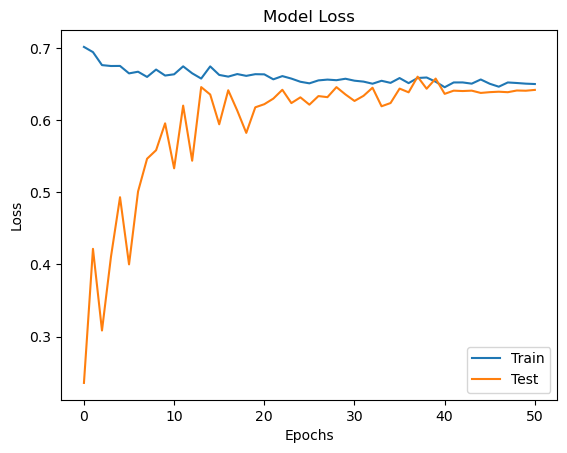

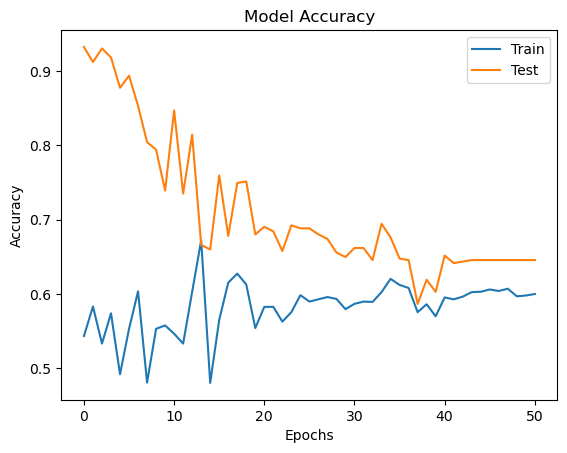

In [19]:
# plotting performance
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

In [20]:
# idea: we could try  and build models for every district, since different districts may have different trends
# we might be mixing too many trends here and that's why our model is not performing well

In [21]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

confusion_matrix(y_test, y_pred)

26/26 [==============================] - 0s 397us/step


array([[ 77,  67],
       [274, 400]])

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.22      0.53      0.31       144
           1       0.86      0.59      0.70       674

    accuracy                           0.58       818
   macro avg       0.54      0.56      0.51       818
weighted avg       0.74      0.58      0.63       818



In [23]:
# recording our results
# 3 labels: 55.3% accuracy
# 4 labels: 31.66% accuracy
# 5 labels: 22.13% accuracy
# 6 labels: 20.78% accuracy
# 7 labels: 26% accuracy
# 8 labels: 24.8% accuracy
# 9 labels: 24.9% accuracy
# 10 labels: 24.8% accuracy
# 11 labels: 25.18% accuracy
# 12 labels: 25.67% accuracy
# 13 labels: 25.41% accuracy